In [1]:
import torch
import numpy as np
import os,sys
sys.path.append('../..')
#parametres 
data_set_name='gowalla'
device='cuda:0'
topk=20
optimizer=lambda params: torch.optim.Adam(params, lr=1e-3, amsgrad=True)
have_processed_data=True

emb_dim=96
sum_pooling=False
sample_negative_num=60
feature_groups=[20,20,10,10,2,2,2,1,1,1]
train_sample_seg_cnt=10#the training data is located in the train_sample_seg_cnt datafiles
parall=10
seq_len=70 # se_len-1 is the number of behaviours in all the windows
min_seq_len=15
test_user_num=6000# the number of user in test file
raw_data_file='../../data/{}/{}.txt'.format(data_set_name,data_set_name)
train_instances_file='../../data/{}/train_instances'.format(data_set_name)
test_instances_file='../../data/{}/test_instances'.format(data_set_name)
validation_instances_file='../../data/{}/validation_instances'.format(data_set_name)
item_num_node_num_file='../../data/{}/item_node_num.txt'.format(data_set_name)



test_batch_size=100

batch_number=80000#
if device!='cpu':
    torch.cuda.set_device(device)
    device='cuda'
%load_ext autoreload
%autoreload 2


In [2]:
import lib
from lib import generate_train_and_test_data
import gc
import numpy as np
if not have_processed_data: 
    behavior_dict, train_sample, test_sample ,user_num,item_num,item_vec= generate_train_and_test_data._read(raw_data_file, 'train.dat', 'test.dat',
                                                                            test_user_num)  # 20 is the test users
    # write the training instance into different train_sample_seg_cnt files， avoid that a file is too large
    # stat record the click frequency of each item
    # seq_len=20 min that 19 behaviors and one label
    stat = generate_train_and_test_data._gen_train_sample(train_sample, train_instances_file,test_sample=test_sample,
                                                    train_sample_seg_cnt=train_sample_seg_cnt,
                                                    parall=parall, seq_len=seq_len, min_seq_len=min_seq_len)
    generate_train_and_test_data._gen_test_sample(test_sample, test_instances_file, seq_len=seq_len,
                                            min_seq_len=min_seq_len)
    del behavior_dict
    del train_sample
    del test_sample
    del stat
    np.savetxt(item_num_node_num_file,np.array([user_num,item_num]),fmt='%d',delimiter=',')
else:
    [user_num,item_num]=np.loadtxt(item_num_node_num_file,dtype=np.int32,delimiter=',')
print('user num is {}, item is {}'.format(user_num,item_num))

user num is 13583, item is 71436


In [3]:
from lib import DINTrain

train_model=DINTrain(item_num=item_num,
                     sample_negative_num=sample_negative_num,
                     emb_dim=emb_dim,
                     device=device,
                     sum_pooling=sum_pooling,
                     feature_groups=feature_groups,
                     optimizer=optimizer)
print(train_model.DINModel)

DeepInterestNetwork(
  (item_embedding): EmbeddingLayer(
    (embed): Embedding(71437, 96, padding_idx=71436)
  )
  (attention_unit): LocalActivationUnit(
    (fc1): FullyConnectedLayer(
      (fc): Sequential(
        (0): Linear(in_features=384, out_features=64, bias=True)
        (1): Dice(
          (bn): BatchNorm1d(64, eps=1e-09, momentum=0.1, affine=True, track_running_stats=True)
          (sigmoid): Sigmoid()
        )
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=64, out_features=16, bias=True)
      )
    )
    (fc2): FullyConnectedLayer(
      (fc): Sequential(
        (0): Linear(in_features=16, out_features=1, bias=True)
      )
    )
  )
  (fc_layer): FullyConnectedLayer(
    (fc): Sequential(
      (0): Linear(in_features=1056, out_features=200, bias=True)
      (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dice(
        (bn): BatchNorm1d(200, eps=1e-09, momentum=0.1, affine=True, track_runn

In [4]:
from lib.generate_training_batches import Train_instance
train_instances=Train_instance(parall=parall)
#training_batch_generator=train_instances.training_batches(train_instances_file,train_sample_seg_cnt,item_num,batchsize=training_batch_size)
training_data,training_labels=train_instances.get_training_data(train_instances_file,train_sample_seg_cnt,item_num)
#test_batch_generator=train_instances.test_batches(test_instances_file,item_num,batchsize=test_batch_size)
validation_batch_generator=train_instances.validation_batches(validation_instances_file,item_num,batchsize=test_batch_size)
test_instances=train_instances.read_test_instances_file(test_instances_file,item_num)

In [5]:
from pandas import DataFrame
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values
loss_history,dev_precision_history,dev_recall_history,dev_f_measure_history,dev_novelty_history,policy_acc=[],[],[],[],[],[]
total_precision_history,total_recall_history,total_f_measure_history,total_novelty_history=[],[],[],[]

In [6]:
def presision(result_list,gt_list,top_k):
    count=0.0
    for r,g in zip(result_list,gt_list):
        count+=len(set(r).intersection(set(g)))
    return count/(top_k*len(result_list))
def recall(result_list,gt_list):
    t=0.0
    for r,g in zip(result_list,gt_list):
        t+=1.0*len(set(r).intersection(set(g)))/len(g)
    return t/len(result_list)
def f_measure(result_list,gt_list,top_k,eps=1.0e-9):
    f=0.0
    for r,g in zip(result_list,gt_list):
        recc=1.0*len(set(r).intersection(set(g)))/len(g)
        pres=1.0*len(set(r).intersection(set(g)))/top_k
        if recc+pres<eps:
            continue
        f+=(2*recc*pres)/(recc+pres)
    return f/len(result_list)
def novelty(result_list,s_u,top_k):
    count=0.0
    for r,g in zip(result_list,s_u):
        count+=len(set(r)-set(g))
    return count/(top_k*len(result_list))
def hit_ratio(result_list,gt_list):
    intersetct_set=[len(set(r)&set(g)) for r,g in zip(result_list,gt_list)]
    return 1.0*sum(intersetct_set)/sum([len(gts) for gts in gt_list])

def NDCG(result_list,gt_list):
    t=0.0
    for re,gt in zip(result_list,gt_list):
        setgt=set(gt)
        indicator=np.asfarray([1 if r in setgt else 0 for r in re])
        sorted_indicator=indicator[indicator.argsort(-1)[::-1]]
        if 1 in indicator:
            t+=np.sum(indicator / np.log2(1.0*np.arange(2,len(indicator)+ 2)))/\
               np.sum(sorted_indicator/np.log2(1.0*np.arange(2,len(indicator)+ 2)))
    return t/len(gt_list)

def MAP(result_list,gt_list,topk):
    t=0.0
    for re,gt in zip(result_list,gt_list):
        setgt=set(gt)
        indicator=np.asfarray([1 if r in setgt else 0 for r in re])
        t+=np.mean([indicator[:i].sum(-1)/i for i in range(1,topk+1)],axis=-1)
    return t/len(gt_list)

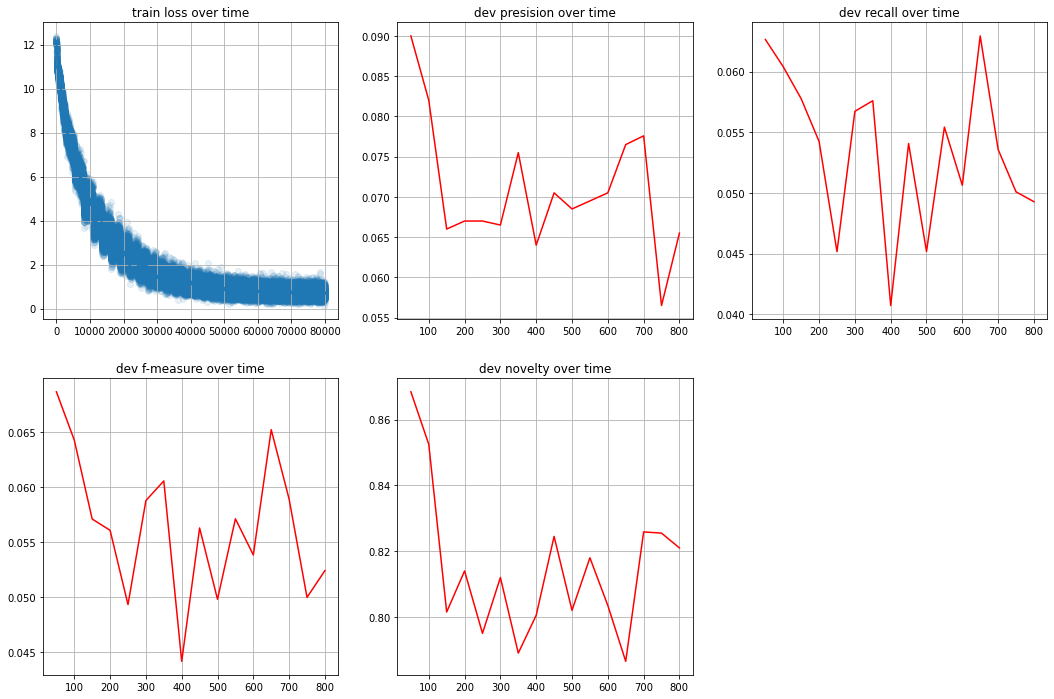

step=80000, mean_loss=0.697, time=1.000
____________________________________________________________________________________________________


In [7]:
#train_model.DINModel.train()
validation_batch_generator=train_instances.validation_batches(validation_instances_file,item_num,batchsize=test_batch_size)
for (batch_x,batch_y) in train_instances.generate_training_records(training_data,training_labels,batch_size=256):
    #print(batch_x,batch_y)
    loss=train_model.update_DIN(batch_x,batch_y)
    loss_history.append(loss.item())
    
    if train_model.batch_num%5000==0:
        # train_model.DINModel.eval()
        # resutl_history=train_model.predict(test_instances,topk=topk).numpy()#40 is N
        # total_precision_history.append(presision(resutl_history,train_instances.test_labels,topk))
        # total_recall_history.append(recall(resutl_history,train_instances.test_labels))
        # total_f_measure_history.append(f_measure(resutl_history,train_instances.test_labels,topk))
        # total_novelty_history.append(novelty(resutl_history,test_instances.tolist(),topk))
        # train_model.DINModel.train()

        # ###start to test
        train_model.DINModel.eval()
        test_batch,test_index=validation_batch_generator.__next__()
        gt_history=[train_instances.validation_labels[i.item()] for i in test_index]

        all_items=torch.arange(item_num,device=device).view(-1,1)
        preference_matrix=torch.full((len(test_batch),item_num),-1.0e9,dtype=torch.float32)
        batch_size=2000
        f_num=test_batch.shape[1]
        #print(item_num,test_batch.shape)
        for i,user in enumerate(test_batch):
            start_id=0
            while start_id<item_num:
                part_labels=all_items[start_id:start_id+batch_size,:]
                #print(len(part_labels),)
                with torch.no_grad():
                    preference_matrix[i,start_id:start_id+batch_size]=train_model.calculate_preference(\
                        user.to(device).expand(len(part_labels),f_num),part_labels).view(1,-1).cpu()
                start_id=start_id+batch_size
        resutl_history=preference_matrix.argsort(dim=-1)[:,-topk:].numpy()
        total_precision_history.append(presision(resutl_history,gt_history,topk))
        total_recall_history.append(recall(resutl_history,gt_history))
        total_f_measure_history.append(f_measure(resutl_history,gt_history,topk))
        total_novelty_history.append(novelty(resutl_history,test_batch.tolist(),topk))
        train_model.DINModel.train()
        # #######


            
    if train_model.batch_num% 100 == 0:
        
        # ###start to test
        # train_model.DINModel.eval()
        # test_batch,test_index=validation_batch_generator.__next__()
        # gt_history=[train_instances.validation_labels[i.item()] for i in test_index]
        # resutl_history=train_model.predict(test_batch,topk=topk).numpy()
        # dev_precision_history.append(presision(resutl_history,gt_history,topk))
        # dev_recall_history.append(recall(resutl_history,gt_history))
        # dev_f_measure_history.append(f_measure(resutl_history,gt_history,topk))
        # dev_novelty_history.append(novelty(resutl_history,test_batch.tolist(),topk))
        # train_model.DINModel.train()
        # #######
            

        clear_output(True)
        plt.figure(figsize=[18, 12])
        plt.subplot(2, 3, 1)
        plt.title('train loss over time'); plt.grid();
        plt.plot(moving_average(loss_history, span=50))
        plt.scatter(range(len(loss_history)), loss_history, alpha=0.1)

        plt.subplot(2, 3, 2)
        plt.title('dev presision over time'); plt.grid();
        # plt.plot(moving_average(dev_precision_history, span=50))
        # plt.scatter(range(len(dev_precision_history)), dev_precision_history, alpha=0.1)
        plt.plot(50*(np.arange(len(total_precision_history)) + 1), total_precision_history, c='r')
        
        plt.subplot(2, 3, 3)
        plt.title('dev recall over time'); plt.grid();
        # plt.plot(moving_average(dev_recall_history, span=10))
        # plt.scatter(range(len(dev_recall_history)), dev_recall_history, alpha=0.1)
        plt.plot(50*(np.arange(len(total_recall_history)) + 1), total_recall_history, c='r')
        
        plt.subplot(2, 3, 4)
        plt.title('dev f-measure over time'); plt.grid();
        # plt.plot(moving_average(dev_f_measure_history, span=10))
        # plt.scatter(range(len(dev_f_measure_history)), dev_f_measure_history, alpha=0.1)
        plt.plot(50*(np.arange(len(total_f_measure_history)) + 1), total_f_measure_history, c='r')
        
        plt.subplot(2, 3, 5)
        plt.title('dev novelty over time'); plt.grid();
        # plt.plot(moving_average(dev_novelty_history, span=10))
        # plt.scatter(range(len(dev_novelty_history)), dev_novelty_history, alpha=0.1)
        plt.plot(50*(np.arange(len(total_novelty_history)) + 1), total_novelty_history, c='r')
        
        plt.show()
        
        print("step=%i, mean_loss=%.3f, time=%.3f" % 
              (len(loss_history), np.mean(loss_history[-100:]),1.0))
        print('_' * 100)
    
    if train_model.batch_num>batch_number:
        break
        '''
        np.savetxt(result_prefix+"prob_loss.txt",np.array(loss_history),fmt='%f')
        np.savetxt(result_prefix+"prob_policy_acc.txt",np.array(policy_acc),fmt='%f')
        
        np.savetxt(result_prefix+"prob_dev_precision.txt",np.array(dev_precision_history),fmt='%f')
        np.savetxt(result_prefix+"prob_total_precision.txt",np.array(total_precision_history),fmt='%f')
        
        np.savetxt(result_prefix+"prob_dev_recall.txt",np.array(dev_recall_history),fmt='%f')
        np.savetxt(result_prefix+"prob_total_recall.txt",np.array(total_recall_history),fmt='%f')
        
        np.savetxt(result_prefix+"prob_dev_f_measure.txt",np.array(dev_f_measure_history),fmt='%f')
        np.savetxt(result_prefix+"prob_total_f_measure.txt",np.array(total_f_measure_history),fmt='%f')
        
        np.savetxt(result_prefix+"prob_dev_novelty.txt",np.array(dev_novelty_history),fmt='%f')
        np.savetxt(result_prefix+"prob_total_novelty.txt",np.array(total_novelty_history),fmt='%f')
        '''
        

In [8]:
# train_model.DINModel.eval()
# resutl_history=train_model.predict(test_instances,topk=topk).numpy()#40 is N
# total_precision_history.append(presision(resutl_history,train_instances.test_labels,topk))
# total_recall_history.append(recall(resutl_history,train_instances.test_labels))
# total_f_measure_history.append(f_measure(resutl_history,train_instances.test_labels,topk))
# total_novelty_history.append(novelty(resutl_history,test_instances.tolist(),topk))
# train_model.DINModel.train()


train_model.DINModel.eval()
gt_history=train_instances.test_labels
all_items=torch.arange(item_num,device=device).view(-1,1)
preference_matrix=torch.full((len(test_instances),item_num),-1.0e9,dtype=torch.float32)
batch_size=2000
f_num=test_instances.shape[1]
#print(item_num,test_batch.shape)
for i,user in enumerate(test_instances):
    start_id=0
    while start_id<item_num:
        part_labels=all_items[start_id:start_id+batch_size,:]
        #print(len(part_labels),)
        with torch.no_grad():
            preference_matrix[i,start_id:start_id+batch_size]=train_model.calculate_preference(\
                user.to(device).expand(len(part_labels),f_num),part_labels).view(1,-1).cpu()
        start_id=start_id+batch_size
resutl_history=preference_matrix.argsort(dim=-1)[:,-topk:].numpy()
total_precision_history.append(presision(resutl_history,gt_history,topk))
total_recall_history.append(recall(resutl_history,gt_history))
total_f_measure_history.append(f_measure(resutl_history,gt_history,topk))
total_novelty_history.append(novelty(resutl_history,test_batch.tolist(),topk))
train_model.DINModel.train()

DeepInterestNetwork(
  (item_embedding): EmbeddingLayer(
    (embed): Embedding(71437, 96, padding_idx=71436)
  )
  (attention_unit): LocalActivationUnit(
    (fc1): FullyConnectedLayer(
      (fc): Sequential(
        (0): Linear(in_features=384, out_features=64, bias=True)
        (1): Dice(
          (bn): BatchNorm1d(64, eps=1e-09, momentum=0.1, affine=True, track_running_stats=True)
          (sigmoid): Sigmoid()
        )
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=64, out_features=16, bias=True)
      )
    )
    (fc2): FullyConnectedLayer(
      (fc): Sequential(
        (0): Linear(in_features=16, out_features=1, bias=True)
      )
    )
  )
  (fc_layer): FullyConnectedLayer(
    (fc): Sequential(
      (0): Linear(in_features=1056, out_features=200, bias=True)
      (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dice(
        (bn): BatchNorm1d(200, eps=1e-09, momentum=0.1, affine=True, track_runn

In [9]:
DIN_Model_path='../../data/{}/DIN_MODEL.pt'.format(data_set_name)
torch.save(train_model.DINModel,DIN_Model_path)
print(total_precision_history[-1],total_recall_history[-1],total_f_measure_history[-1],total_novelty_history[-1])

0.06737849779086892 0.04883386726625865 0.05214716403638074 0.07352724594992636


In [10]:
sorted_test_users_path='../../data/{}/sorted_test_users.txt'.format(data_set_name)
np.savetxt(sorted_test_users_path,preference_matrix.argsort(dim=-1).numpy(),delimiter=',',fmt='%d')

In [11]:
def presision(result_list,gt_list,top_k):
    count=0.0
    for r,g in zip(result_list,gt_list):
        count+=len(set(r).intersection(set(g)))
    return count/(top_k*len(result_list))
def recall(result_list,gt_list):
    t=0.0
    for r,g in zip(result_list,gt_list):
        t+=1.0*len(set(r).intersection(set(g)))/len(g)
    return t/len(result_list)
def f_measure(result_list,gt_list,top_k,eps=1.0e-9):
    f=0.0
    for r,g in zip(result_list,gt_list):
        recc=1.0*len(set(r).intersection(set(g)))/len(g)
        pres=1.0*len(set(r).intersection(set(g)))/top_k
        if recc+pres<eps:
            continue
        f+=(2*recc*pres)/(recc+pres)
    return f/len(result_list)
def novelty(result_list,s_u,top_k):
    count=0.0
    for r,g in zip(result_list,s_u):
        count+=len(set(r)-set(g))
    return count/(top_k*len(result_list))
def hit_ratio(result_list,gt_list):
    intersetct_set=[len(set(r)&set(g)) for r,g in zip(result_list,gt_list)]
    return 1.0*sum(intersetct_set)/sum([len(gts) for gts in gt_list])

def NDCG(result_list,gt_list):
    t=0.0
    for re,gt in zip(result_list,gt_list):
        setgt=set(gt)
        indicator=np.asfarray([1 if r in setgt else 0 for r in re])
        sorted_indicator=indicator[indicator.argsort(-1)[::-1]]
        if 1 in indicator:
            t+=np.sum(indicator / np.log2(1.0*np.arange(2,len(indicator)+ 2)))/\
               np.sum(sorted_indicator/np.log2(1.0*np.arange(2,len(indicator)+ 2)))
    return t/len(gt_list)

def MAP(result_list,gt_list,topk):
    t=0.0
    for re,gt in zip(result_list,gt_list):
        setgt=set(gt)
        indicator=np.asfarray([1 if r in setgt else 0 for r in re])
        t+=np.mean([indicator[:i].sum(-1)/i for i in range(1,topk+1)],axis=-1)
    return t/len(gt_list)

In [12]:
from lib.generate_training_batches import Train_instance
train_instances=Train_instance(parall=parall)
test_instances=train_instances.read_test_instances_file(test_instances_file,item_num)

In [13]:
sorted_test_users_path='../../data/{}/sorted_test_users.txt'.format(data_set_name)
gt_history=train_instances.test_labels
preference_matrix=np.loadtxt(sorted_test_users_path,delimiter=',')

In [14]:
topk=40
resutl_history=np.array(preference_matrix[:,-1:-topk-1:-1],dtype=np.int32)
P = presision(resutl_history,gt_history,topk)
R = recall(resutl_history,gt_history)
F = f_measure(resutl_history,gt_history,topk)
N = novelty(resutl_history,test_instances.tolist(),topk)
hr_ = hit_ratio(resutl_history,gt_history)
ndcg_ = NDCG(resutl_history,gt_history)
map_ = MAP(resutl_history,gt_history,topk)
print("{:.4f}   {:.4f}   {:.4f}   {:.4f}   {:.4f}   {:.4f}   {:.4f}".format(P,R,F,N,hr_,ndcg_,map_))

0.0597   0.0862   0.0645   0.8646   0.0677   0.3107   0.0667


In [15]:
np.array(preference_matrix,dtype=np.int32)

array([[38416, 10050, 55251, ..., 17425, 18166, 14176],
       [40272, 27950,  6942, ..., 16475, 15175, 14557],
       [14788, 15876, 36508, ..., 11431, 24091, 64567],
       ...,
       [31506, 25586, 12826, ..., 34842, 43117, 43768],
       [38416, 12826, 37819, ...,  7072, 37917, 66366],
       [68041, 38416, 65219, ..., 13329, 11693, 25804]], dtype=int32)